In [11]:
%load_ext autoreload

# Enable autoreload for all modules
%autoreload 2

import sys
sys.path.append("..")

from loader import data_loader
import numpy as np 
import matplotlib.pyplot as plt
import torch

from graph_plotting import graph_2D

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool
from models import graph_classifier, gnn_models
from torch_geometric.loader import DataLoader


from evaluation import evaluation
from graph_plotting import graph_2D


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
octa_dr_dict = {"Healthy": 0, "DM": 0, "PDR": 1, "Early NPDR": 2, "Late NPDR": 2}

HeteroDataLoader = data_loader.HeteroGraphLoaderTorch("/media/data/alex_johannes/octa_data/Cairo/SCP_vessel_graph",
                                                        "/media/data/alex_johannes/octa_data/Cairo/SCP_void_graph",
                                                        "/media/data/alex_johannes/octa_data/Cairo/SCP_heter_edges",
                                                        label_file = "/media/data/alex_johannes/octa_data/Cairo/labels.csv", 
                                                        line_graph_1 =True, 
                                                        class_dict = octa_dr_dict)

no label for  0009_OD
no label for  0288_OD
no label for  0414_OD
no label for  0505_OD
no label for  0505_OS
no label for  0631_OD
no label for  0009_OD
no label for  0288_OD


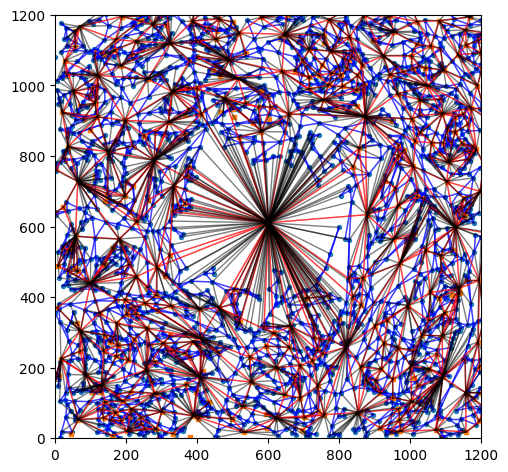

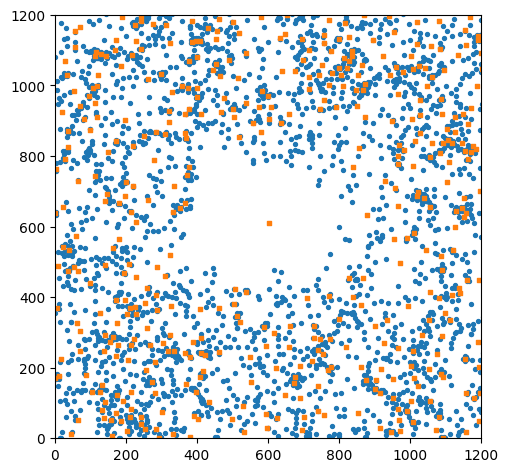

In [113]:
id = "0499_OS"

g_plotter = graph_2D.HeteroGraphPlotter2D()
g_plotter.plot_graph_2D(HeteroDataLoader.hetero_graphs[id], edges=True)
g_plotter.plot_graph_2D(HeteroDataLoader.hetero_graphs[id], edges=False)

In [52]:
for key, data in HeteroDataLoader.hetero_graphs.items():
    # check if the .x and .edge_index contains nan values
    for key, val in data.x_dict.items():
        if torch.any(torch.isnan(val)):
            print("nan values in x")
            nan_pos = torch.where(torch.isnan(val))
            val[nan_pos] = 0
        if torch.any(torch.isinf(val)):
            #print("inf values in x")
            # find position of inf values and replace inf by 0
            inf_pos = torch.where(torch.isinf(val))
            val[inf_pos] = 0
    for key, val in data.edge_index_dict.items():
        if torch.any(torch.isnan(val)):
            print("nan values in edge_index")

In [53]:
np.random.seed(123)

work_data = list(HeteroDataLoader.hetero_graphs.values())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_mask = np.random.choice(np.arange(0, len(work_data)), size= int(len(work_data)*0.8), replace = False)
test_mask = np.delete(np.arange(0, len(work_data)), train_mask)

train_list_bin = []
test_list_bin = []


for i, data in enumerate(work_data):
    if i in train_mask:
        train_list_bin.append(data.clone().to(device))
    else:
        test_list_bin.append(data.clone().to(device))


In [54]:
print(np.unique([data.y.clone().cpu() for data in train_list_bin], return_counts=True)[1]/len(train_list_bin))
print(len(train_list_bin))
print(np.unique([data.y.clone().cpu() for data in test_list_bin], return_counts=True)[1]/len(test_list_bin))
print(len(test_list_bin))

[0.73648649 0.08558559 0.17792793]
444
[0.76785714 0.05357143 0.17857143]
112


Epoch: 001, Loss: 0.035455, Train Acc: 0.1396, Test Acc: 0.0982, Test Bal Acc: 0.3655
Epoch: 002, Loss: 0.030403, Train Acc: 0.2613, Test Acc: 0.2679, Test Bal Acc: 0.4238
Epoch: 003, Loss: 0.029482, Train Acc: 0.5113, Test Acc: 0.4821, Test Bal Acc: 0.5434
Epoch: 004, Loss: 0.030250, Train Acc: 0.7387, Test Acc: 0.7857, Test Bal Acc: 0.4961
Epoch: 005, Loss: 0.029669, Train Acc: 0.4054, Test Acc: 0.3571, Test Bal Acc: 0.5275
Epoch: 006, Loss: 0.028611, Train Acc: 0.7320, Test Acc: 0.7857, Test Bal Acc: 0.4056
Epoch: 007, Loss: 0.028928, Train Acc: 0.3739, Test Acc: 0.3036, Test Bal Acc: 0.5048
Epoch: 008, Loss: 0.030051, Train Acc: 0.6374, Test Acc: 0.6429, Test Bal Acc: 0.6137
Epoch: 009, Loss: 0.028425, Train Acc: 0.7477, Test Acc: 0.7768, Test Bal Acc: 0.3889
Epoch: 010, Loss: 0.028183, Train Acc: 0.4640, Test Acc: 0.4018, Test Bal Acc: 0.5469
Epoch: 011, Loss: 0.027967, Train Acc: 0.7297, Test Acc: 0.8125, Test Bal Acc: 0.5451
Epoch: 012, Loss: 0.027571, Train Acc: 0.7523, Test Ac

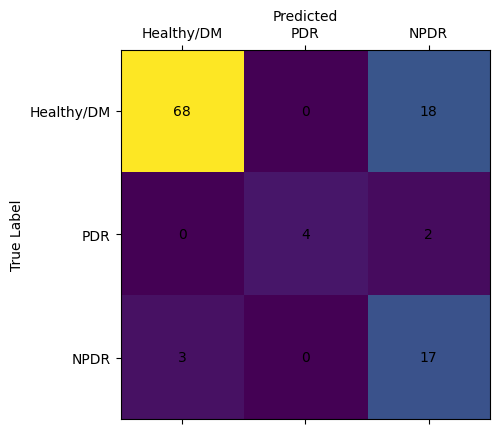

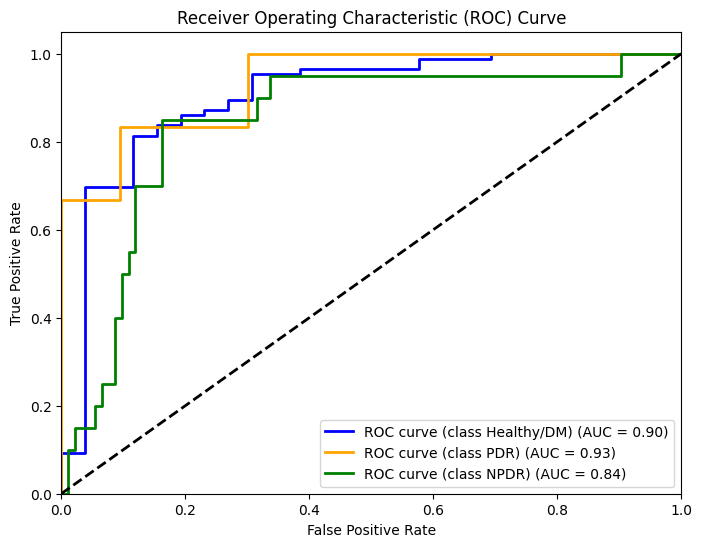

In [118]:
num_classes = 3
epochs = 200
node_types = ["graph_1", "graph_2"]

# create the model
model = gnn_models.HeteroGNN(hidden_channels = 64, 
                          out_channels= num_classes, 
                          num_layers= 3, 
                          dropout = 0.1, 
                          aggregation_mode= global_mean_pool,
                          node_types = node_types,
                          )

# create data loaders for training and test set
train_loader = DataLoader(train_list_bin, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_list_bin, batch_size = 1, shuffle=False)


# weigthings for imbalanced classes 
train_labels = [lab["y"].cpu() for lab in train_list_bin]
weights = 1/np.unique(train_labels, return_counts= True)[1]
balanced_loss = torch.nn.CrossEntropyLoss(torch.tensor(weights).to(device).float())
unbalanced_loss = torch.nn.CrossEntropyLoss() # use when the training data is already balanced


classifier = graph_classifier.graphClassifierHetero(model, train_loader, test_loader, balanced_loss)


for epoch in range(1, epochs+1):
    loss = classifier.train()
    train_acc = classifier.test(train_loader)
    outList, yList = classifier.predict(test_loader)
    #print(outList)
    y_p = np.array([item.argmax().cpu().detach().numpy() for sublist in outList for item in sublist])
    y_t = np.array([item.detach().cpu().numpy() for sublist in yList for item in sublist])
    print(f'Epoch: {epoch:03d}, Loss: {loss:.6f}, Train Acc: {train_acc:.4f}, Test Acc: {accuracy_score(y_t, y_p):.4f}, Test Bal Acc: {balanced_accuracy_score(y_t, y_p):.4f}')

    if balanced_accuracy_score(y_t, y_p) > 0.70:
        fig, ax = plt.subplots()
        evaluation.plot_confusion_matrix(y_t, y_p, ["Healthy/DM", "PDR", "NPDR"], ax) # , 3, 4
        plt.show()
        evaluation.plot_roc_curve(y_t, torch.nn.functional.softmax(torch.tensor(np.array(outList).squeeze()), dim = 1), class_labels = ["Healthy/DM", "PDR", "NPDR"]) # , 3, 4
        break



In [79]:
print(y_p)
print(y_t)
test_idcs = np.array(list(HeteroDataLoader.hetero_graphs.keys()))[test_mask]
print(test_idcs)
print(test_idcs[y_p != y_t])

[0 0 0 0 2 0 0 2 2 2 0 0 0 0 0 2 2 2 2 2 2 2 2 0 2 0 2 0 1 2 0 0 0 2 0 0 2
 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 1 0 2 2 2 0 0 0 0 2 2 0 0 0 2
 0 0 0 0 0 0 0 2 0 0 2 0 2 0 2 2 0 1 0 2 0 0 0 1 0 0 0 2 0 0 0 0 1 0 0 0 2
 0]
[0 0 0 0 1 0 0 0 0 2 0 0 0 0 0 0 2 0 0 2 2 2 2 0 0 0 2 0 1 2 0 0 0 2 0 0 2
 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 2 2 0 0 0 0 0 0 0 0 0 2
 0 0 0 0 0 2 0 0 0 0 0 0 0 2 2 0 0 2 2 0 0 0 0 1 0 0 0 2 0 0 0 0 1 0 0 0 1
 0]
['0003_OD' '0003_OS' '0004_OD' '0022_OD' '0023_OS' '0024_OD' '0024_OS'
 '0036_OD' '0037_OD' '0059_OS' '0066_OS' '0072_OS' '0075_OD' '0080_OS'
 '0095_OS' '0098_OS' '0100_OD' '0106_OS' '0138_OD' '0145_OD' '0148_OD'
 '0148_OS' '0156_OS' '0162_OS' '0168_OD' '0169_OD' '0170_OS' '0185_OD'
 '0196_OS' '0206_OS' '0212_OS' '0213_OD' '0219_OS' '0221_OD' '0233_OS'
 '0238_OS' '0269_OS' '0277_OS' '0283_OS' '0289_OD' '0297_OD' '0304_OS'
 '0323_OD' '0331_OS' '0337_OD' '0353_OS' '0355_OD' '0372_OD' '0386_OS'
 '0387_OD' '0403_OD' '0416_OD' '0425_OS' '043

In [100]:
np.where(test_idcs == id)[0][0]

36

(array([62]),)
Predicted Class [2]
True Class [2]
Probability tensor([[-0.7102, -0.1640,  0.5930]])


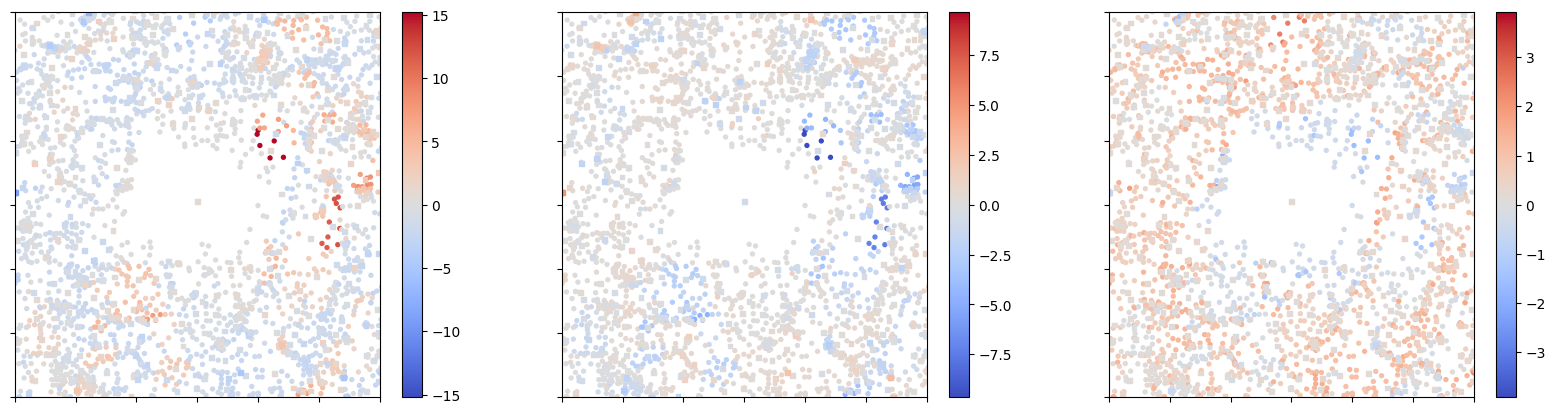

In [119]:
id = "0499_OS"

print(np.where(test_idcs == id))
print("Predicted Class", y_p[np.where(test_idcs == id)])
print("True Class", y_t[np.where(test_idcs == id)])
print("Probability", outList[np.where(test_idcs == id)[0][0]])
# now 
eval_data = HeteroDataLoader.hetero_graphs[id].clone().to(device)
pred_val = model.vals_without_aggregation(eval_data.x_dict,eval_data.edge_index_dict)


fig, ax = plt.subplots(1,3, figsize=(20,5))
g_plotter = graph_2D.HeteroGraphPlotter2D()
g_plotter.set_cls(0)
g_plotter.plot_graph_2D(HeteroDataLoader.hetero_graphs[id], pred_val_dict=pred_val, edges=False, ax = ax[0])
g_plotter.set_cls(1)
g_plotter.plot_graph_2D(HeteroDataLoader.hetero_graphs[id], pred_val_dict=pred_val, edges=False, ax = ax[1])
g_plotter.set_cls(2)
g_plotter.plot_graph_2D(HeteroDataLoader.hetero_graphs[id], pred_val_dict=pred_val, edges=False, ax = ax[2])

In [18]:
for key, data in HeteroDataLoader.line_graphs_1.items():
    # check if the .x and .edge_index contains nan values
    if torch.any(torch.isnan(data.x)):
        nan_pos = torch.where(torch.isnan(data.x))
        data.x[nan_pos] = 0
        print("nan values in x")
    if torch.any(torch.isinf(data.x)):
        #print("inf values in x")
        # find position of inf values and replace inf by 0
        inf_pos = torch.where(torch.isinf(data.x))
        data.x[inf_pos] = 0

In [19]:
np.random.seed(0)

work_data_line_graphs_1 = list(HeteroDataLoader.line_graphs_1.values())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_mask = np.random.choice(np.arange(0, len(work_data)), size= int(len(work_data)*0.8), replace = False)
test_mask = np.delete(np.arange(0, len(work_data)), train_mask)

train_list_bin_line_graphs_1 = []
test_list_bin_line_graphs_1 = []

for i, data in enumerate(work_data_line_graphs_1):
    if i in train_mask:
        train_list_bin_line_graphs_1.append(data.clone().to(device))
    else:
        test_list_bin_line_graphs_1.append(data.clone().to(device))

In [21]:
# selection of the features to use
num_features = train_list_bin_line_graphs_1[0].x.shape[1]
num_classes = 2
epochs = 50

# create the model
model = gnn_models.GNN(in_channels= num_features, hidden_channels = 64, out_channels= num_classes, num_layers= 5, dropout = 0.2, aggregation_mode= global_mean_pool)

# create brach data loaders for training and test set
train_loader_line_graphs_1 = DataLoader(train_list_bin_line_graphs_1, batch_size = 32, shuffle=True)
test_loader_line_graphs_1 = DataLoader(test_list_bin_line_graphs_1, batch_size = 1, shuffle=False)

# weigthings for imbalanced classes 
train_labels_line_graphs_1 = [lab["y"].cpu() for lab in train_list_bin_line_graphs_1]
weights = 1/np.unique(train_labels_line_graphs_1, return_counts= True)[1]
balanced_loss = torch.nn.CrossEntropyLoss(torch.tensor(weights).to(device).float())
unbalanced_loss = torch.nn.CrossEntropyLoss() # use when the training data is already balanced

# trainloader can be anything 
classifier = graph_classifier.graphClassifierClassic(model, train_loader_line_graphs_1, test_loader_line_graphs_1, balanced_loss)


for epoch in range(1, epochs+1):
    loss = classifier.train()
    train_acc = classifier.test(train_loader_line_graphs_1)
    #test_acc = classifier.test(test_loader_line_graphs_1)
    outList, yList = classifier.predict(test_loader_line_graphs_1)
    y_p = np.array([item.argmax().cpu().detach().numpy() for sublist in outList for item in sublist])
    y_t = np.array([item.detach().cpu().numpy() for sublist in yList for item in sublist])
    print(f'Epoch: {epoch:03d}, Loss: {loss:.6f}, Train Acc: {train_acc:.4f}, Test Acc: {accuracy_score(y_t, y_p):.4f}, Test Bal Acc: {balanced_accuracy_score(y_t, y_p):.4f}')


fig, ax = plt.subplots()
evaluation.plot_confusion_matrix(y_t, y_p, [0, 1, 2], ax)

Epoch: 001, Loss: 0.023446, Train Acc: 0.3401, Test Acc: 0.2957, Test Bal Acc: 0.5422
Epoch: 002, Loss: 0.021863, Train Acc: 0.4212, Test Acc: 0.3907, Test Bal Acc: 0.5959
Epoch: 003, Loss: 0.021718, Train Acc: 0.7815, Test Acc: 0.7447, Test Bal Acc: 0.7057
Epoch: 004, Loss: 0.021599, Train Acc: 0.7545, Test Acc: 0.7755, Test Bal Acc: 0.5000


KeyboardInterrupt: 

In [33]:
np.random.seed(0)

work_data_full_graphs_2 = list(HeteroDataLoader.full_graphs_2.values())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_mask = np.random.choice(np.arange(0, len(work_data)), size= int(len(work_data)*0.8), replace = False)
test_mask = np.delete(np.arange(0, len(work_data)), train_mask)

train_list_bin_full_graphs_2 = []
test_list_bin_full_graphs_2 = []

for i, data in enumerate(work_data_full_graphs_2):
    if i in train_mask:
        train_list_bin_full_graphs_2.append(data.clone().to(device))
    else:
        test_list_bin_full_graphs_2.append(data.clone().to(device))

Epoch: 001, Loss: 1.738850, Train Acc: 0.2635, Test Acc: 0.2321, Test Bal Acc: 0.5000
Epoch: 002, Loss: 0.795939, Train Acc: 0.6982, Test Acc: 0.7143, Test Bal Acc: 0.6261
Epoch: 003, Loss: 0.485097, Train Acc: 0.7297, Test Acc: 0.7679, Test Bal Acc: 0.5000
Epoch: 004, Loss: 0.290332, Train Acc: 0.6689, Test Acc: 0.5982, Test Bal Acc: 0.5908
Epoch: 005, Loss: 0.250603, Train Acc: 0.7365, Test Acc: 0.7679, Test Bal Acc: 0.5000
Epoch: 006, Loss: 0.220160, Train Acc: 0.7523, Test Acc: 0.7500, Test Bal Acc: 0.5286
Epoch: 007, Loss: 0.222723, Train Acc: 0.7365, Test Acc: 0.7321, Test Bal Acc: 0.5707
Epoch: 008, Loss: 0.177549, Train Acc: 0.7432, Test Acc: 0.7411, Test Bal Acc: 0.4826
Epoch: 009, Loss: 0.146013, Train Acc: 0.6869, Test Acc: 0.6607, Test Bal Acc: 0.6717
Epoch: 010, Loss: 0.128883, Train Acc: 0.7500, Test Acc: 0.7411, Test Bal Acc: 0.5094
Epoch: 011, Loss: 0.145037, Train Acc: 0.7230, Test Acc: 0.6875, Test Bal Acc: 0.6355
Epoch: 012, Loss: 0.113561, Train Acc: 0.7455, Test Ac

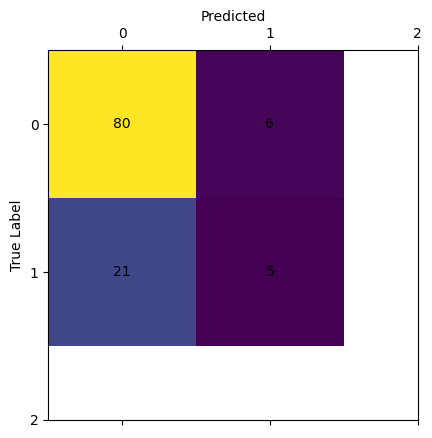

In [34]:
# selection of the features to use
num_features = train_list_bin_full_graphs_2[0].x.shape[1]
num_classes = 2
epochs = 50

# create the model
model = gnn_models.GNN(in_channels= num_features, hidden_channels = 64, out_channels= num_classes, num_layers= 5, dropout = 0.2, aggregation_mode= global_mean_pool)

# create brach data loaders for training and test set
train_loader_full_graphs_2 = DataLoader(train_list_bin_full_graphs_2, batch_size = 32, shuffle=True)
test_loader_full_graphs_2 = DataLoader(test_list_bin_full_graphs_2, batch_size = 1, shuffle=False)

# weigthings for imbalanced classes 
train_labels_full_graphs_2 = [lab["y"].cpu() for lab in train_list_bin_full_graphs_2]
weights = 1/np.unique(train_labels_full_graphs_2, return_counts= True)[1]
balanced_loss = torch.nn.CrossEntropyLoss(torch.tensor(weights).to(device).float())
unbalanced_loss = torch.nn.CrossEntropyLoss() # use when the training data is already balanced

# trainloader can be anything 
classifier = graph_classifier.graphClassifierClassic(model, train_loader_full_graphs_2, test_loader_full_graphs_2, balanced_loss)


for epoch in range(1, epochs+1):
    loss = classifier.train()
    train_acc = classifier.test(train_loader_full_graphs_2)
    #test_acc = classifier.test(test_loader_full_graphs_2)
    outList, yList = classifier.predict(test_loader_full_graphs_2)
    y_p = np.array([item.argmax().cpu().detach().numpy() for sublist in outList for item in sublist])
    y_t = np.array([item.detach().cpu().numpy() for sublist in yList for item in sublist])
    print(f'Epoch: {epoch:03d}, Loss: {loss:.6f}, Train Acc: {train_acc:.4f}, Test Acc: {accuracy_score(y_t, y_p):.4f}, Test Bal Acc: {balanced_accuracy_score(y_t, y_p):.4f}')


fig, ax = plt.subplots()
evaluation.plot_confusion_matrix(y_t, y_p, [0, 1], ax)